In [ ]:
#conda activate ciao

In [2]:
import numpy as np
import torch
from sbi import utils as utils
from sbi import analysis as analysis
#from utils.data_formats import timeseries_to_channels
from simulators import Simulator
from sbi.inference import SNRE_B, SNLE, prepare_for_sbi, simulate_for_sbi
from sbi.neural_nets.embedding_nets import FCEmbedding, CNNEmbedding, PermutationInvariantEmbedding
from sbi_tools import BoxUniform
from sbi.inference import SNPE
from sbi.utils import posterior_nn
from sherpa.astro import xspec
from matplotlib import pyplot as plt

In [3]:


# define energy bin lower and upper bounds
e_lo = np.linspace(0.3, 10.99, 1070)
e_hi = np.linspace(0.31, 11.00, 1070)
e_bar = (e_lo + e_hi) / 2

Reading APEC data from 3.0.9



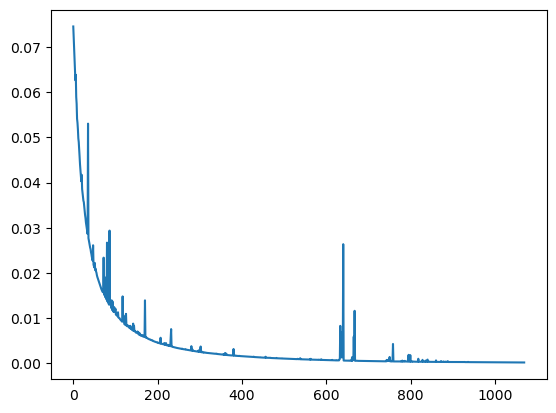

In [4]:
m = xspec.XSvapec()
m.kT = 7.0
m.norm = 6.0

plt.plot(m(e_lo, e_hi))

In [6]:
m?

Signature:   m(*args, **kwargs)
Type:        XSvapec
String form:
vapec
           Param        Type          Value          Min          Max      Units
           -----        -- <...>            10
           vapec.norm   thawed            6            0        1e+24
File:        ~/opt/anaconda3/envs/ciao/lib/python3.11/site-packages/sherpa/astro/xspec/__init__.py
Docstring:  
The XSPEC vapec model: APEC emission spectrum.

The model is described at [1]_, with ``XSapec`` describing how
it is implemented in Sherpa.

Attributes
----------
kT
    The temperature of the plasma, in keV.
He, C, N, O, Ne, Mg, Al, Si, S, Ar, Ca, Fe, Ni
    The abundance of the element in solar units.
redshift
    The redshift of the plasma.
norm
    The normalization of the model: see [1]_ for an explanation
    of the units.

See Also
--------
XSapec, XSbapec, XSbvapec, XSbvvapec, XSvvapec

References
----------

.. [1] https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/XSmodelApec.html

In [6]:
from simulators import Simulator
from inputs import process_rmf

RMF = process_rmf(np.loadtxt('source_analysis/rmf.txt'))
ARF = np.loadtxt('source_analysis/arf.txt')
x0 = np.loadtxt('source_analysis/counts.txt')

class XspecModel:
    def __init__(self):
        self.model = xspec.XSvapec()

    def get_rate(self, params):
        self.model.kT = params[0]
        self.model.norm = params[1]
        return self.model(e_lo, e_hi)

def simulate_simple(params):
    model = XspecModel()
    simulator =  Simulator(model, int(np.sum(x0)), pileup='channels', in_RMF=RMF, in_ARF=ARF, in_ENERGY_BINS=e_bar)
    data = simulator(params)
    return np.bincount(data[data>0], minlength=len(x0)+1)

In [7]:
prior = BoxUniform(low=torch.tensor([0.1, 0.1]), high=torch.tensor([50, 50]))

In [8]:
simulator, prior = prepare_for_sbi(simulate_simple, prior)
rounds = 5
num_sims = 10

inference = SNPE(prior=prior)
proposal = prior
for _ in range(rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_sims)
    print ('simulated')
    _ = inference.append_simulations(theta, x, proposal=proposal).train()
    print ('simulations appended')
    posterior = inference.build_posterior().set_default_x(x0)
    print ('postedrior built')
    proposal = posterior
    print ('round+1')

samples = posterior.sample((10000,), x=x0)
fig, axes = analysis.pairplot(
    samples,
    limits=[[0.1, 1], [0.1, 2]],
    ticks=[[0.1, 1], [0.1, 2]],
    figsize=(5, 5),
    points_offdiag={"markersize": 6},
    points_colors="r",
)

Running 10 simulations.:   0%|          | 0/10 [00:00<?, ?it/s]

simulated


In [1]:
plt.plot(simulate_simple([20,20]))

NameError: name 'plt' is not defined

In [37]:
RMF = np.loadtxt('rmf.txt')

FileNotFoundError: rmf.txt not found.

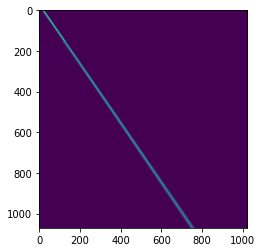

In [7]:
plt.imshow(RMF)

In [8]:
arf = np.loadtxt('arf.txt')

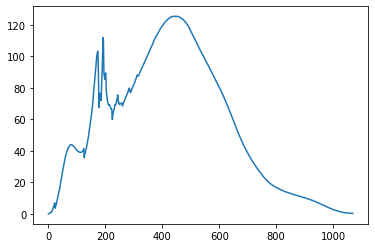

In [9]:
plt.plot(arf)

In [10]:
plt.plot(counts/arf)

ValueError: operands could not be broadcast together with shapes (1024,) (1070,) 